# Predicting painters from paintings


<img src="https://i.imgur.com/Sy6ZvCW.jpg" alt="Van Gogh" style="width: 400px;"/>

### Challenge: to correctly predict the genre of a painting


If you haven't already downloaded the data for this tutorial you can get it here: 

* Train: https://www.dropbox.com/s/qvpycfo1bzy2wru/train.zip?dl=1
* Test: https://www.dropbox.com/s/kqwkn1lyokedq93/test.zip?dl=1

You'll also need the ground truth data from here: https://www.dropbox.com/s/gsvmct6zjd68w4s/train_info.csv?dl=1

If you don't have space for all of this a small set of training images is available here: https://www.dropbox.com/s/ffygkyo3ug7coae/train_5000.zip?dl=1

## Images as tensors

Tensors are a general way of describing pretty much anything:

* Scalar value: 0-dimensional tensor
* Vector: 1-dimensional tensor
* Matrix: 2-dimensional tensor
* Volume: 3-dimensional tensor
* ... and so on

The reason we're bringing these up is that when working with images, we very often need to adopt a *tensor-based representation*.

![tensors](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/Images/enter-the-matrix-10-638.jpg)

Let's see how this works in practice. We have a bunch of images in a folder numbered from 1 - n, and a CSV file with the labels.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import pandas as pd

img_list = []
labels = []
csv_file = pd.read_csv('train_info.csv', index_col=0)

img_rows = img_cols = 128  # go smaller if you don't have a GPU...    

for img_path in glob('train/*.jpg')[:5000]:
    
    img = np.asarray(Image.open(img_path).resize((img_rows, img_cols)))  
    img_list.append(img)  # not an ND array at this point, just a list of 3D arrays
    
    base_name = os.path.basename(img_path)
    label = csv_file.loc[base_name, 'genre']
    labels.append(label)

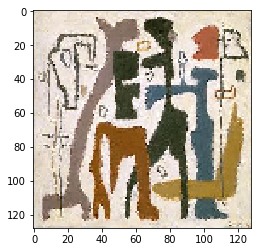

In [3]:
plt.imshow(img_list[9])

Paintings! Let's stick them in a tensor.

In [4]:
X = np.stack(img_list, axis=0)
y = np.asarray(labels)
print(X.shape)
print(y.shape)

(5000, 128, 128, 3)
(5000,)


This is what we would call the "TensorFlow" standard: ```samples x rows x columns x channels```. We'll be using this representation a lot.

Let's see who these artists are:

In [5]:
print(labels)

['illustration', 'portrait', 'portrait', 'portrait', 'genre painting', 'portrait', 'illustration', 'literary painting', 'genre painting', 'figurative', 'genre painting', 'abstract', 'still life', 'sketch and study', 'religious painting', 'figurative', 'cityscape', nan, 'portrait', 'landscape', 'genre painting', 'cityscape', 'religious painting', 'abstract', 'portrait', 'flower painting', 'cityscape', 'landscape', 'landscape', 'genre painting', 'symbolic painting', 'portrait', 'marina', 'genre painting', 'cityscape', 'landscape', 'landscape', 'mythological painting', 'history painting', 'symbolic painting', 'portrait', 'religious painting', 'genre painting', 'genre painting', 'sketch and study', 'cityscape', 'portrait', 'cityscape', 'still life', 'abstract', 'genre painting', 'religious painting', 'cityscape', 'portrait', 'genre painting', 'cityscape', 'nude painting (nu)', 'cloudscape', 'portrait', 'sketch and study', 'landscape', 'landscape', 'landscape', 'nude painting (nu)', 'marina

Hmm. Not quite Picasso or Cezanne, but clearly some unique identifier. We could try to predict these directly, but let's simplify things a little.

We are going to use a format known as "one-hot encoding" for this, which produces a binary-valued vector for each entry:

![onehot](https://i.imgur.com/mtimFxh.png)

In [6]:
y = pd.get_dummies(pd.Series(labels))
print(y.shape[1])
y.head(10)

41


,abstract,advertisement,allegorical painting,animal painting,battle painting,bijinga,bird-and-flower painting,calligraphy,capriccio,caricature,...,self-portrait,shan shui,sketch and study,still life,symbolic painting,tessellation,vanitas,veduta,wildlife painting,yakusha-e
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Let's check by looking at the first 10 entries
assert(list(y.idxmax(axis=1).head(10)) == labels[:10])  # if these wasn't true, Python would complain

# Convolution

Convolution, in the context of images, is the process of applying a 'filter' to an image. This animation does a great job of illustrating how this process works. Our original image is in <span style="color: blue;">blue</span>. The "filter" is shown as a 3x3 grid in <span style="color: gray;">gray</span>. The resulting filtered image is shown in <span style="color: green;">green</span>.

The convolution operation (often denoted by a $*$) is a the integral (sum) of an element-wise multiplication of the image region and our chosen filter. The size of the filter (and corresponding image region) is called the *receptive field*.

![conv](https://cdn-images-1.medium.com/max/1200/1*1okwhewf5KCtIPaFib4XaA.gif)

Let's implement a convolution which serves to detect images in an image. First, let's define a 3x3 kernel:

[[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]


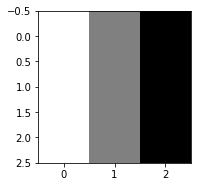

In [8]:
sobel_x = np.asarray([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
print(sobel_x)
plt.subplot(1, 2, 2)
plt.imshow(sobel_x, cmap='gray')

Now let's define a function to perform a convolution using arbitrary input. **Note:** this is phenomenally inefficient, and is not how TensorFlow implements it!

In [9]:
def conv_2d(img, kernel):
    
    padded = np.pad(img, ((1, 1), (1, 1)), mode='reflect')
    rows, cols = img.shape[:2]
    feature_map = np.zeros(shape=img.shape)
    
    for r in range(1, rows-1):
        for c in range(1, cols-1):

            patch = padded[r-1:r+2, c-1:c+2]
            feature_map[r-1, c-1] = np.sum(patch * kernel)
    
    return feature_map

(-0.5, 127.5, 127.5, -0.5)

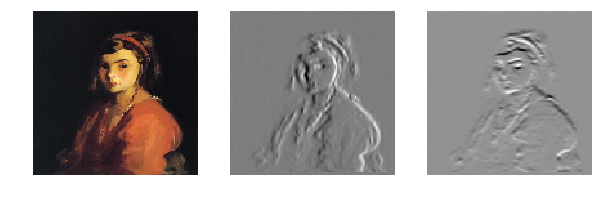

In [10]:
plt.figure(figsize=(10, 20))

# Let's just grab the red channel for now
img = img_list[3]
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')

# Sobel X
img = img[:, :, 0]
edges_x = conv_2d(img, sobel_x)
plt.subplot(1, 3, 2)
plt.imshow(edges_x, cmap='gray')
plt.axis('off')

# Sobel Y
sobel_y = sobel_x.T  # the tranpose of X
edges_y = conv_2d(img, sobel_y)
plt.subplot(1, 3, 3)
plt.imshow(edges_y, cmap='gray')
plt.axis('off')

Haunting. But, but as you can hopefully see, the Sobel filter is one of several well-known *edge detector* filters. There are many other kinds - try some random ones and see what happens!

# ...but why?

Convolution operations can reveal *features* of an image that might be predictive of the art style (and therefore the artist). Some filters might help to quantify the color palette, whereas as others might quantify certain shapes or strokes.

As it happens, we can simply use multiple filters to emphasise a wider range of features. Let's generate some random filters for fun:

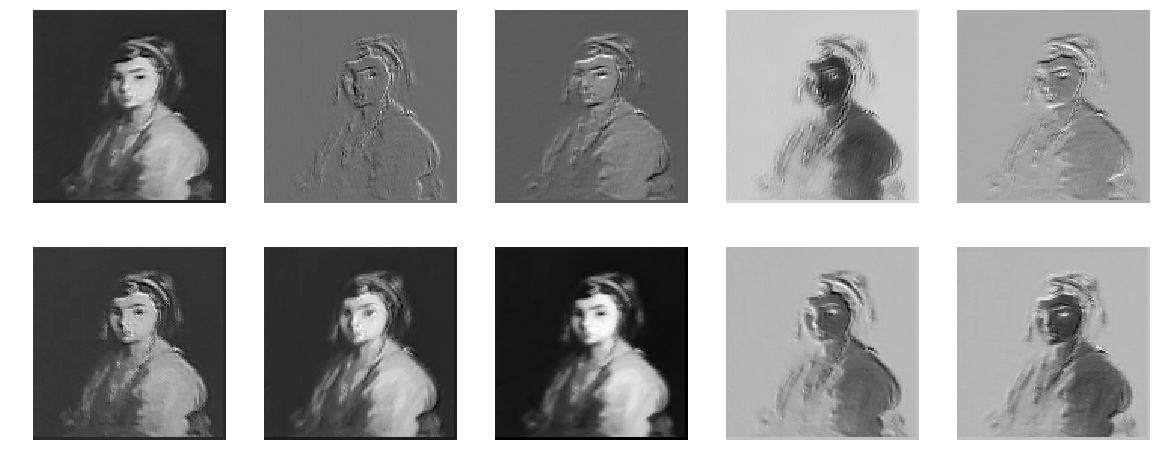

In [11]:
plt.figure(figsize=(20, 8))
feature_maps = []

for i in range(1, 11):
    
    plt.subplot(2, 5, i)
    kernel = np.random.uniform(-1, 1, (3, 3))
    plt.axis('off')
    
    features = conv_2d(img, kernel)
    plt.imshow(features, cmap='gray')
    feature_maps.append(features)

Even random kernels produce some interesting results, but there's still too much information here. Can we reduce feature maps in size, but still preserve the most useful information?

# Pooling

The pooling operation reduces the image dimensions by taking the max, min, or average of small regions. Let's implement that too:

In [12]:
def pool_2d(img, pool_size=(2,2), method=np.max):
    
    rows, cols = img.shape[:2]
    pooled = np.zeros(shape=(rows//pool_size[0], cols//pool_size[1]))
    
    for r in range(0, rows, pool_size[0]):
        for c in range(0, cols, pool_size[1]):

            patch = img[r:r+pool_size[0], c:c+pool_size[1]]
            pooled[r//2, c//2] = method(patch)
            
    return pooled

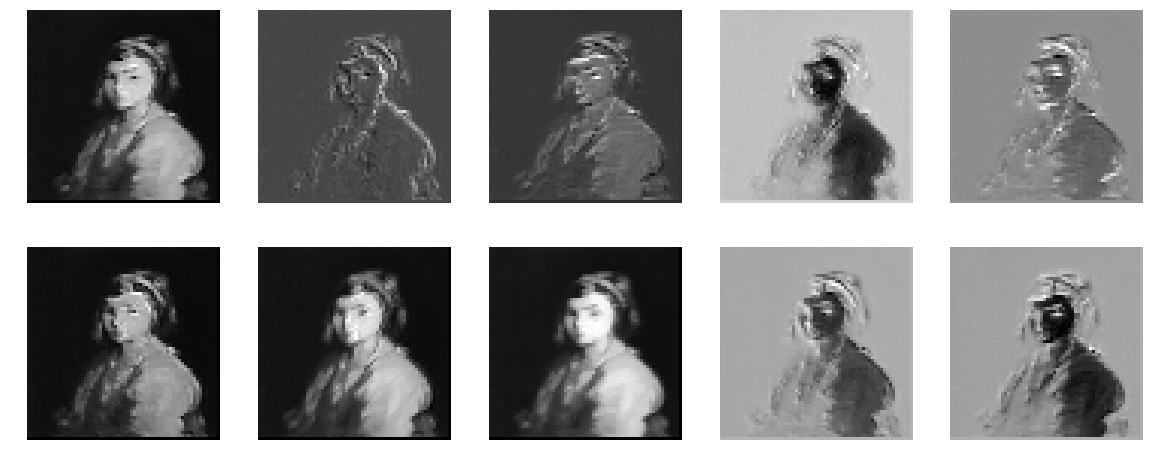

In [13]:
plt.figure(figsize=(20, 8))
pooled = []
for i, f in enumerate(feature_maps):
    
    plt.subplot(2, 5, i+1)
    p = pool_2d(f)
    plt.imshow(p, cmap='gray')
    plt.axis('off')
    pooled.append(p)

These two operations - *convolution* and *pooling* are the building blocks of the **convolutional neural network!**

# Convolutional neural networks

The basic idea behind a convolutional neural network (CNN) is to apply a series of successive convolution and pooling operations to extract image features. The key thing is the kernels are not pre-defined (like the sobel filter) but they are *learned* by the network.

![convnet](http://cs231n.github.io/assets/cnn/cnn.jpeg)

One we have the features, we can classify them using any classifier we want. However, it is commonplace to use a neural network for classification, too. This means that we can train our whole network end-to-end.

![mlp](https://dzone.com/storage/temp/3627042-mlp-network.png)


We are going to define a simple CNN using the ``keras`` library, which is a wrapper around TensorFlow.

In [14]:
import os  # set the keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import keras.backend as K
K.set_image_dim_ordering('tf')

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D

input_ = Input(shape=(img_rows, img_cols, 3))

conv1 = Conv2D(8, (3, 3), padding='same')(input_)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), padding='same')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(32, (3, 3), padding='same')(pool3)
pool4 = MaxPooling2D((2, 2))(conv4)

model = Model(inputs=input_, outputs=pool4)

In [16]:
pooled = model.predict(np.expand_dims(img_list[2], axis=0))
print(pooled.shape)

(1, 8, 8, 32)


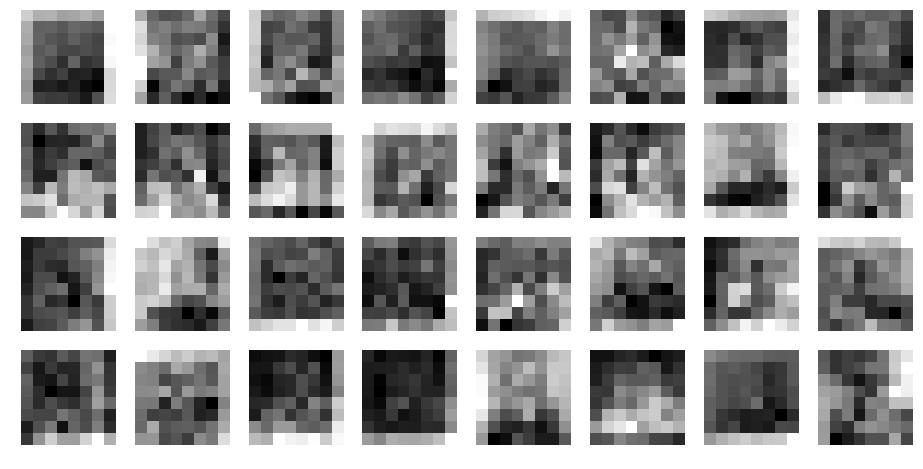

In [17]:
plt.figure(figsize=(16, 8))

for i, f in enumerate(range(pooled.shape[-1])):
    
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(pooled[0, :, :, f], cmap='gray')

We haven't trained this model yet, but it's intersting to observe how a series of simple operations produce increasingly abstract representations of our original image. Let's train!

We'll use a deeper network and some extra layers:

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

input_ = Input(shape=(img_rows, img_cols, 3))

conv1 = Conv2D(8, (3, 3), padding='same')(input_)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), padding='same')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(32, (3, 3), padding='same')(pool3)
pool4 = MaxPooling2D((2, 2))(conv4)

### The new stuff ###
flat = Flatten()(conv4)  # samples x rows x cols x channels --> samples x features
dense1 = Dense(128, activation='relu')(flat)  # features --> features
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(y.shape[1], activation='softmax')(drop1)  # features --> (pseudo-)probabilities

model = Model(inputs=input_, outputs=dense2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

One key thing we've overlooked is something called *activation*. In most real-world applications, our desired outputs are complex non-linear functions of the input data.

![nonlin](https://qph.fs.quoracdn.net/main-qimg-5cf3edc38978dd54c91e29ea4aa3a446)

Vanilla neural networks just a series of weighted sums, which are just linear functions. We don't want to restricted ourselve to the domain of linear functions, so we introduce some non-linearity in the form of activation functions such as sigmoid or ReLU (rectified linear unit):

![act](https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png)

In [19]:
from keras.callbacks import TensorBoard
cb = TensorBoard(log_dir='tb_log')
model.fit(X, y, epochs=50, batch_size=50, shuffle=True, validation_split=0.1, callbacks=[cb])

Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 5s 1ms/step - loss: 15.1674 - acc: 0.0478 - val_loss: 15.1510 - val_acc: 0.0500
Epoch 2/50
4500/4500 [==============================] - 4s 832us/step - loss: 15.6192 - acc: 0.0211 - val_loss: 15.7635 - val_acc: 0.0120
Epoch 3/50
4500/4500 [==============================] - 4s 824us/step - loss: 15.6704 - acc: 0.0180 - val_loss: 15.7635 - val_acc: 0.0120
Epoch 4/50
4500/4500 [==============================] - 4s 826us/step - loss: 15.6310 - acc: 0.0204 - val_loss: 15.7635 - val_acc: 0.0120
Epoch 5/50
4500/4500 [==============================] - 4s 835us/step - loss: 15.6775 - acc: 0.0176 - val_loss: 15.7635 - val_acc: 0.0120
Epoch 6/50
3050/4500 [===================>..........] - ETA: 1s - loss: 15.6795 - acc: 0.0187

KeyboardInterrupt: 

## What went wrong?

So, we didn't do all that well. What did we do wrong?

* Data: not enough/not diverse enough/imbalanced?
* Architecture: too shallow/deep?
* Hyperparameters: learning rates/activations/regularization?
* Is this problem just too hard for deep learning?

We are going to explore all of these areas in future tutorials, as these ideas are key to getting deep learning to work. In the meantime, let's try one last thing - a pre-trained network. This network is called MobileNet, and is a very slim but powerful network that has been pre-trained on 1.2 million images like these:

![imagenet](http://karpathy.github.io/assets/cnntsne.jpeg)


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.callbacks import TensorBoard

# Here, we take just the convolutional/pooling layers from the network
base_model = MobileNet(input_shape=(img_rows, img_cols, 3), weights='imagenet', include_top=False)

# Flatten the features, add regularization, and add a softmax layer
flat = Flatten()(base_model.output)
drop1 = Dropout(0.5)(flat)
dense1 = Dense(128, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense1)
dense2 = Dense(y.shape[1], activation='softmax')(drop2)

model = Model(inputs=base_model.input, outputs=dense2)
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

cb = TensorBoard(log_dir='tb_log')
model.fit(X, y, epochs=50, batch_size=50, shuffle=True, validation_split=0.1, callbacks=[cb])

Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 16s 4ms/step - loss: 4.0050 - acc: 0.2098 - val_loss: 3.1080 - val_acc: 0.2540
Epoch 2/50
4500/4500 [==============================] - 13s 3ms/step - loss: 3.0996 - acc: 0.2431 - val_loss: 3.3094 - val_acc: 0.1660
Epoch 3/50
4500/4500 [==============================] - 13s 3ms/step - loss: 2.7648 - acc: 0.2960 - val_loss: 2.8354 - val_acc: 0.2940
Epoch 4/50
4500/4500 [==============================] - 13s 3ms/step - loss: 2.5377 - acc: 0.3427 - val_loss: 6.7323 - val_acc: 0.2180
Epoch 5/50
4500/4500 [==============================] - 13s 3ms/step - loss: 2.4443 - acc: 0.3453 - val_loss: 5.7663 - val_acc: 0.3200
Epoch 6/50
4500/4500 [==============================] - 13s 3ms/step - loss: 2.6097 - acc: 0.3551 - val_loss: 8.4591 - val_acc: 0.1540
Epoch 7/50
4500/4500 [==============================] - 13s 3ms/step - loss: 2.4764 - acc: 0.3513 - val_loss: 3.0034 - val_acc: 0.2940
Epoch 8/